In [1]:
using Pkg

Pkg.activate(mktempdir())
Pkg.update()

Pkg.add([
    "Yao",
    "CUDA",
    "MLDatasets",
    "Plots",
    "Statistics",
    "Random"
])

  Activating new project at `C:\Users\79021\AppData\Local\Temp\jl_h4o6mj`
    Updating registry at `C:\Users\79021\.julia\registries\General.toml`
     Project No packages added to or removed from `C:\Users\79021\AppData\Local\Temp\jl_h4o6mj\Project.toml`
    Manifest No packages added to or removed from `C:\Users\79021\AppData\Local\Temp\jl_h4o6mj\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\79021\AppData\Local\Temp\jl_h4o6mj\Project.toml`
  [052768ef] + CUDA v5.9.5
  [eb30cadb] + MLDatasets v0.7.19
  [91a5bcdd] + Plots v1.41.3
  [10745b16] + Statistics v1.11.1
  [5872b779] + Yao v0.9.2
  [9a3f8284] + Random v1.11.0
    Updating `C:\Users\79021\AppData\Local\Temp\jl_h4o6mj\Manifest.toml`
Precompiling packages...
    627.8 ms  ✓ CUDA_Driver_jll
   1436.4 ms  ✓ CUDA_Runtime_jll
  2 dependencies successfully precompiled in 2 seconds. 29 already precompiled.
  [621f4979] + AbstractFFTs v1.5.0
  [1520ce14] + AbstractTrees v0.4.5
  [7d9f7c33] + Accessors v0.1.43
  

In [67]:
# ============================================================================
# PACKAGE IMPORTS AND GPU SETUP
# ============================================================================
# This cell loads all necessary packages and configures GPU acceleration

using Yao          # Quantum computing framework for building and simulating quantum circuits
using CUDA         # GPU acceleration library
using MLDatasets   # Provides access to common ML datasets including Iris
using Plots        # Visualization library for plotting results
using Statistics   # Statistical functions (mean, std, etc.)
using Random       # Random number generation and seeding

# Set random seed for reproducibility - ensures same results across runs
Random.seed!(42)

# ============================================================================
# GPU DETECTION AND CONFIGURATION
# ============================================================================
# Check if GPU is available and configure quantum circuit execution
global USE_GPU = false  # Initialize to false, will be set to true if GPU works

if CUDA.functional()
    # GPU hardware detected
    println("✓ GPU detected: $(CUDA.name(CUDA.device()))")
    println("✓ VRAM: $(CUDA.totalmem(CUDA.device()) ÷ 1024^3) GB")
    
    # Test if Yao's CUDA extension works properly
    # The CUDA extension allows quantum registers to be moved to GPU for faster computation
    try
        test_reg = zero_state(2) |> cu  # Create 2-qubit state and move to GPU
        test_reg |> cpu                  # Move back to CPU and clean up
        println("✓ Yao CUDA extension loaded successfully")
        global USE_GPU = true
    catch e
        # CUDA available but Yao extension failed - fall back to CPU
        println("✗ Warning: CUDA available but Yao CUDA extension failed")
        println("  Error: $e")
        println("  Falling back to CPU")
    end
else
    # No GPU detected - will use CPU only
    println("✗ No GPU detected, running on CPU")
end

println("\nPackages loaded successfully!")

✓ GPU detected: NVIDIA GeForce RTX 3050 Ti Laptop GPU
✓ VRAM: 3 GB
✓ Yao CUDA extension loaded successfully

Packages loaded successfully!


### Data preparation

Load and preprocess the Iris dataset:
- 150 sample total (120 train, 30 test)
- 4 features: sepal length, sepal width, petal length, petal width
- 3 classes: setosa, versicolor, virginica

In [68]:
# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================
# Load the Iris dataset and prepare it for quantum machine learning

# Fix for VS Code: Accept dataset download automatically without user prompt
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

function load_and_prepare_iris()
    """
    Load and preprocess the Iris dataset for quantum classification.
    
    Steps:
    1. Load raw Iris data (150 samples, 4 features, 3 classes)
    2. Convert string labels to integers (0, 1, 2)
    3. Normalize features to [0, 1] range (required for quantum encoding)
    4. Split into train (120 samples) and test (30 samples) sets
    
    Returns:
        X_train: Training features (120 × 4)
        y_train: Training labels (120,)
        X_test: Test features (30 × 4)
        y_test: Test labels (30,)
    """
    # Load Iris dataset (features are rows, need to transpose)
    iris = Iris(as_df=false)
    
    # Transpose features: (4 × 150) → (150 × 4)
    # Each row is now a sample, each column is a feature
    X = Float64.(iris.features')
    y_raw = iris.targets  # String labels: "Iris-setosa", "Iris-versicolor", "Iris-virginica"
    
    # Convert string labels to integers for easier processing
    # Iris-setosa → 0, Iris-versicolor → 1, Iris-virginica → 2
    label_map = Dict("Iris-setosa" => 0, "Iris-versicolor" => 1, "Iris-virginica" => 2)
    y = [label_map[String(label)] for label in y_raw]
    
    # ========================================================================
    # FEATURE NORMALIZATION (Critical for quantum encoding)
    # ========================================================================
    # Quantum rotations work best with angles in [0, π], so we scale features to [0, 1]
    
    # Step 1: Z-score normalization (mean=0, std=1)
    X_mean = mean(X, dims=1)
    X_std = std(X, dims=1)
    X_normalized = (X .- X_mean) ./ (X_std .+ 1e-8)  # Add epsilon to avoid division by zero
    
    # Step 2: Shift to positive range and scale to [0, 1]
    # Assuming normalized data is roughly in [-3, 3], we shift and scale
    X_scaled = (X_normalized .+ 3.0) ./ 6.0
    X_scaled = clamp.(X_scaled, 0.0, 1.0)  # Ensure all values are in [0, 1]
    
    # ========================================================================
    # TRAIN/TEST SPLIT
    # ========================================================================
    n_samples = size(X, 1)  # 150 samples
    indices = randperm(n_samples)  # Randomly shuffle indices
    
    n_train = 120  # 80% for training
    train_idx = indices[1:n_train]
    test_idx = indices[n_train+1:end]  # Remaining 30 samples for testing
    
    # Split data
    X_train = X_scaled[train_idx, :]
    y_train = y[train_idx]
    X_test = X_scaled[test_idx, :]
    y_test = y[test_idx]
    
    return X_train, y_train, X_test, y_test
end

function one_hot_encode(y, n_classes=3)
    """
    Convert integer labels to one-hot encoded vectors.
    
    Example: Label 2 → [0, 0, 1]
    
    Args:
        y: Vector of integer labels (0-indexed)
        n_classes: Number of classes
    
    Returns:
        Y: Matrix of one-hot vectors (n_samples × n_classes)
    """
    n_samples = length(y)
    Y = zeros(n_samples, n_classes)
    for i in 1:n_samples
        # y[i] is 0-indexed, Julia arrays are 1-indexed, so add 1
        Y[i, y[i] + 1] = 1.0
    end
    return Y
end

# ============================================================================
# EXECUTE DATA LOADING
# ============================================================================
X_train, y_train, X_test, y_test = load_and_prepare_iris()
Y_train = one_hot_encode(y_train, 3)  # One-hot encode training labels for loss computation

# Display dataset information
println("Dataset loaded:")
println("Training samples: $(size(X_train, 1))")
println("Test samples: $(size(X_test, 1))")
println("Features: $(size(X_train, 2))")
println("Classes: 3 (labels: 0, 1, 2)")
println("\nFirst training sample:")
println("Features: $(X_train[1, :])")
println("Label: $(y_train[1])")

Dataset loaded:
Training samples: 120
Test samples: 30
Features: 4
Classes: 3 (labels: 0, 1, 2)

First training sample:
Features: [0.5315326396208814, 0.47924327059513655, 0.5983640591603505, 0.6313251788680941]
Label: 2


### Quantum circuit construction

Feature map

Encodes classical data into quantum stated via rotations

Variational layer

Trainable quantum circuit with:

1. Single-qubit rotations on each qubit
2. Ring CNOT entanglement

In [69]:
# ============================================================================
# QUANTUM CIRCUIT CONSTRUCTION
# ============================================================================
# Build the quantum neural network architecture
#
# REAL-WORLD ANALOGY: Building a smart lock system for your house
# - Feature map: Convert your fingerprint/face into the lock's internal code
# - Variational layers: Adjustable tumblers inside the lock (trained to recognize you)
# - Observables: Sensors that check if the tumblers aligned correctly
# - Final output: Lock opens (correct class) or stays closed (wrong class)

function feature_map(n_qubits, x)
    """
    FEATURE ENCODING: Encode classical data into quantum states
    
    REAL-WORLD ANALOGY: Converting your voice into radio waves
    - Your voice (classical data) → microphone → radio frequency (quantum state)
    - Each word's pitch becomes a specific frequency
    - Each word's volume becomes signal amplitude
    
    For Iris dataset:
    - Sepal length 5.1cm → rotation angle 1.6 radians (5.1 * π / 10)
    - Petal width 0.2cm → rotation angle 0.06 radians (0.2 * π / 10)
    
    Why rotations? 
    - Classical bit: 0 or 1 (like a light switch: ON/OFF)
    - Quantum qubit: any angle (like a dimmer: 0% to 100% brightness)
    - More information capacity!
    """
    ops = []

    for i in 1:n_qubits
        # Scale feature values to rotation angles in [0, π]
        # EXAMPLE: If sepal_length = 0.6 (normalized), angle = 0.6π ≈ 108 degrees
        angle_y = π * x[i]
        angle_z = π * x[i]

        # Apply Y and Z rotations to qubit i
        # ANALOGY: Spinning a coin at specific angles before tossing
        # - RY: Rotate around Y-axis (like tilting your head left/right)
        # - RZ: Rotate around Z-axis (like shaking head no)
        push!(ops, put(n_qubits, i => Ry(angle_y)))
        push!(ops, put(n_qubits, i => Rz(angle_z)))
    end
    
    # Chain all operations together
    return chain(n_qubits, ops...)
end

function variational_layer(n_qubits)
    """
    VARIATIONAL QUANTUM LAYER: Trainable quantum circuit
    
    REAL-WORLD ANALOGY: A sophisticated combination lock
    - Each dial (parameter) can be set to any angle
    - The dials are connected (entangled) - turning one affects others
    - During training, we learn the correct combination
    
    WHY TWO PARTS?
    1. Individual rotations: Each qubit learns its own "preference"
       - Like each judge in a talent show having their own criteria
    2. Entangling gates: Qubits share information with neighbors
       - Like judges discussing and influencing each other's scores
    
    ARCHITECTURE EXAMPLE:
    Starting state: |0000⟩ (all qubits in state 0)
    After rotations: Each qubit tilted at a learned angle
    After CNOT gates: Qubits become correlated (quantum entanglement!)
    
    Think of entanglement like synchronized dancers:
    - Before: 4 dancers moving independently
    - After CNOT: When dancer 1 moves left, dancer 2 automatically mirrors
    """
    layer = chain(n_qubits)

    # PART 1: Parameterized single-qubit rotations
    # ANALOGY: Each person adjusting their individual camera settings
    for i in 1:n_qubits
        push!(layer, put(n_qubits, i => Ry(0.0)))  # θ angle (will be learned)
        push!(layer, put(n_qubits, i => Rz(0.0)))  # φ angle (will be learned)
    end

    # PART 2: Entangling layer - Ring topology CNOT gates
    # ANALOGY: Connecting dominoes in a circle
    # - When qubit 1 "falls" (flips), it triggers qubit 2
    # - When qubit 2 falls, it triggers qubit 3, and so on
    # - Qubit 4 connects back to qubit 1 (full circle!)
    #
    # REAL-WORLD EXAMPLE: Synchronized traffic lights
    # - Light 1's state controls light 2
    # - Light 2's state controls light 3
    # - Creates waves of green lights (quantum interference patterns)
    for i in 1:n_qubits
        target_qubit = i == n_qubits ? 1 : i + 1  # Ring: 1→2→3→4→1
        push!(layer, control(n_qubits, i, target_qubit => X))  # CNOT gate
    end

    return layer
end

function build_quantum_classifier(n_qubits, n_layers)
    """
    BUILD COMPLETE QUANTUM CLASSIFIER
    
    REAL-WORLD ANALOGY: Stacking multiple Instagram filters
    - Layer 1: Adjust brightness and contrast
    - Layer 2: Add color grading
    - Layer 3: Apply sharpening
    - More layers = more complex transformations possible
    
    For our model:
    - 4 qubits: Process 4 features simultaneously (parallel processing!)
    - 3 layers: Apply 3 rounds of rotations + entanglement
    - 24 parameters: 3 layers × 4 qubits × 2 rotations = 24 knobs to tune
    
    COMPARISON:
    - 1 layer: Can learn simple patterns (straight lines)
    - 3 layers: Can learn complex patterns (curves, spirals)
    - 10+ layers: Can learn very complex patterns but slower to train
    """
    total_circuit = chain(n_qubits)

    for layer_idx in 1:n_layers
        push!(total_circuit, variational_layer(n_qubits))
    end

    return total_circuit
end

function create_observables(n_qubits, n_classes)
    """
    CREATE MEASUREMENT OBSERVABLES
    
    REAL-WORLD ANALOGY: Quality control sensors in a factory
    - Sensor 1 (Z on qubit 1): Checks if product is type A
    - Sensor 2 (Z on qubit 2): Checks if product is type B  
    - Sensor 3 (Z on qubit 3): Checks if product is type C
    
    QUANTUM MEASUREMENT:
    - Measuring Z gives +1 (qubit is |0⟩) or -1 (qubit is |1⟩)
    - But qubits are in superposition! So we get values like +0.3, -0.7, etc.
    - These values become "scores" for each class
    
    EXAMPLE OUTPUT:
    - Z₁ = +0.8  →  Strong signal for class 0 (Setosa)
    - Z₂ = -0.2  →  Weak signal for class 1 (Versicolor)  
    - Z₃ = -0.4  →  Weak signal for class 2 (Virginica)
    → Prediction: Class 0 (Setosa) with high confidence!
    """
    obsersvables = []

    for class_idx in 1:n_classes
        # Measure Pauli-Z operator on qubit 'class_idx'
        # Z = |0⟩⟨0| - |1⟩⟨1|  (gives +1 for |0⟩, -1 for |1⟩)
        obs = put(n_qubits, class_idx => Z)
        push!(obsersvables, obs)
    end

    return obsersvables
end

# ============================================================================
# TEST CIRCUIT CONSTRUCTION
# ============================================================================
test_circuit = build_quantum_classifier(4, 3)
println("Circuit built successfully!")
println("\nCircuit structure:")
println(test_circuit)
println("\nNumber of parameters: $(nparameters(test_circuit))")
println("  = $(3) layers × $(4) qubits × $(2) rotations = $(3*4*2) parameters")

Circuit built successfully!

Circuit structure:
nqubits: 4
chain
├─ chain
│  ├─ put on (1)
│  │  └─ rot(Y, 0.0)
│  ├─ put on (1)
│  │  └─ rot(Z, 0.0)
│  ├─ put on (2)
│  │  └─ rot(Y, 0.0)
│  ├─ put on (2)
│  │  └─ rot(Z, 0.0)
│  ├─ put on (3)
│  │  └─ rot(Y, 0.0)
│  ├─ put on (3)
│  │  └─ rot(Z, 0.0)
│  ├─ put on (4)
│  │  └─ rot(Y, 0.0)
│  ├─ put on (4)
│  │  └─ rot(Z, 0.0)
│  ├─ control(1)
│  │  └─ (2,) X
│  ├─ control(2)
│  │  └─ (3,) X
│  ├─ control(3)
│  │  └─ (4,) X
│  └─ control(4)
│     └─ (1,) X
├─ chain
│  ├─ put on (1)
│  │  └─ rot(Y, 0.0)
│  ├─ put on (1)
│  │  └─ rot(Z, 0.0)
│  ├─ put on (2)
│  │  └─ rot(Y, 0.0)
│  ├─ put on (2)
│  │  └─ rot(Z, 0.0)
│  ├─ put on (3)
│  │  └─ rot(Y, 0.0)
│  ├─ put on (3)
│  │  └─ rot(Z, 0.0)
│  ├─ put on (4)
│  │  └─ rot(Y, 0.0)
│  ├─ put on (4)
│  │  └─ rot(Z, 0.0)
│  ├─ control(1)
│  │  └─ (2,) X
│  ├─ control(2)
│  │  └─ (3,) X
│  ├─ control(3)
│  │  └─ (4,) X
│  └─ control(4)
│     └─ (1,) X
└─ chain
   ├─ put on (1)
   │  └─ rot(Y, 0.0

### Quantum classifier model

Forward pass computes:
1. Feature encoding
2. Parametrised circuit application
3. Observable measurment
4. Softmax to probabilities

In [70]:
# ============================================================================
# QUANTUM CLASSIFIER MODEL
# ============================================================================
# Define the quantum machine learning model structure and forward pass
#
# REAL-WORLD ANALOGY: Think of this like a special camera filter system:
# - Input photo (classical data) → Apply quantum filters → Measure colors → Output classification
# - The quantum circuit "filters" are adjustable, and we train them to recognize patterns

mutable struct QuantumClassifier
    """
    Quantum Neural Network Classifier
    
    ANALOGY: Like a complex prism that splits light (data) into different colors (classes)
    - The prism's angles (parameters) are adjustable and learned during training
    - Different angles make different patterns visible in the output spectrum
    """
    n_qubits::Int              # Number of qubits (= number of input features)
    n_layers::Int              # Depth of quantum circuit (like stacking multiple prisms)
    n_classes::Int             # Number of output classes (how many colors to detect)
    circuit                    # Variational quantum circuit (the adjustable prism)
    obsersvables              # Measurement operators (color detectors)
    parameters::Vector{Float64}  # Trainable parameters (prism angles)
end

function QuantumClassifier(n_qubits, n_layers, n_classes)
    """
    Constructor: Initialize a quantum classifier
    
    REAL-WORLD EXAMPLE: Setting up a new camera with random initial settings
    - You start with random brightness, contrast, saturation values
    - Through training, you adjust these to get the clearest image
    """
    # Build quantum circuit architecture
    circuit = build_quantum_classifier(n_qubits, n_layers)
    
    # Create measurement observables for classification
    obsersvables = create_observables(n_qubits, n_classes)

    # Initialize trainable parameters with LARGER values for better gradient flow
    # OLD: randn(n_params) * 0.1  ← Too small! Gradients vanish
    # NEW: randn(n_params) * 0.5  ← Better initial diversity
    n_params = nparameters(circuit)
    parameters = (rand(n_params) .- 0.5) * π  # Random angles in [-π/2, π/2]
    
    println("📊 Initialized $(n_params) parameters with random angles in [-π/2, π/2]")

    return QuantumClassifier(n_qubits, n_layers, n_classes, circuit,
        obsersvables, parameters)
end

function forward(model::QuantumClassifier, x)
    """
    FORWARD PASS: Compute class probabilities for input x
    
    REAL-WORLD ANALOGY: Medical diagnosis machine
    1. Patient data (x) → Input
    2. Pass through quantum "analyzer" (circuit with learned parameters)
    3. Measure different health indicators (observables)  
    4. Convert measurements to diagnosis probabilities
    
    Example with Iris flowers:
    - Input: [sepal_length=5.1, sepal_width=3.5, petal_length=1.4, petal_width=0.2]
    - Encode into quantum state (like converting photo to digital)
    - Apply quantum transformations (like applying AI filters)
    - Measure outcomes (like checking which features light up)
    - Output: [P(setosa)=0.9, P(versicolor)=0.08, P(virginica)=0.02]
    """
    # Step 1: Initialize quantum register to |0000⟩
    # ANALOGY: Start with a blank canvas/reset the system
    reg = zero_state(model.n_qubits)
    
    # Step 2: Apply feature encoding (data → quantum state)
    # ANALOGY: Convert your photo's RGB values into the camera's internal format
    # Each feature (sepal length, petal width) becomes a rotation angle
    fm = feature_map(model.n_qubits, x)
    reg = apply(reg, fm)
    
    # Step 3: Set variational circuit parameters
    # ANALOGY: Adjust the camera's learned settings (brightness, contrast, etc.)
    dispatch!(model.circuit, model.parameters)
    
    # Step 4: Move to GPU for faster computation (if available)
    # ANALOGY: Use the graphics card instead of CPU (10-100x speedup)
    if USE_GPU
        reg = reg |> cu
    end
    
    # Step 5: Apply variational quantum circuit
    # ANALOGY: Pass the image through learned AI filters
    # Each layer applies rotations and entanglement (mixing information between qubits)
    reg = apply(reg, model.circuit)

    # Step 6: Measure observables to extract class scores
    # ANALOGY: Check color intensity in different channels (R, G, B)
    # Z measurement gives values in [-1, 1], representing "how much" of each class
    expectations = zeros(model.n_classes)
    for i in 1:model.n_classes
        expectations[i] = real(expect(model.obsersvables[i], reg))
    end

    # Step 7: Convert measurement results to probabilities using softmax
    # ANALOGY: Normalize color values so they sum to 100% (must pick one dominant color)
    probs = softmax(expectations)
    return probs
end

function softmax(x)
    """
    Softmax activation function
    
    REAL-WORLD ANALOGY: Election vote counting
    - Input: Raw vote counts [245, 189, 566]
    - Output: Probabilities [24.5%, 18.9%, 56.6%] (sum = 100%)
    
    Another analogy: Converting test scores to percentages
    - Student A: 85 points → 35% 
    - Student B: 90 points → 37%
    - Student C: 67 points → 28%
    Total: 100%
    """
    exp_x = exp.(x .- maximum(x))  # Numerical stability: subtract max before exp
    return exp_x ./ sum(exp_x)
end

println("Model functions defined successfully!")

Model functions defined successfully!


### Loss and gradient computation

Cross-entropy loss with chain rule through softmax. Yao's expet` quantum gradients automatically.

In [71]:
# ============================================================================
# LOSS AND GRADIENT COMPUTATION
# ============================================================================
# Implement training loss calculation and gradient computation using parameter shift rule

function compute_loss_and_gradient(model::QuantumClassifier, X, Y)
    """
    Compute cross-entropy loss and gradients for the quantum classifier
    
    This function implements:
    1. Forward pass through quantum circuit for each sample
    2. Cross-entropy loss computation
    3. Gradient computation using the PARAMETER SHIFT RULE
    
    PARAMETER SHIFT RULE:
    For quantum circuits with rotation gates R(θ), the gradient is:
        ∂f/∂θ = [f(θ + π/2) - f(θ - π/2)] / 2
    
    This is a quantum-specific gradient computation method that doesn't
    require backpropagation. Instead, we evaluate the circuit twice per
    parameter with shifted values.
    
    Args:
        model: QuantumClassifier instance
        X: Training features (n_samples × n_features)
        Y: One-hot encoded labels (n_samples × n_classes)
    
    Returns:
        avg_loss: Average cross-entropy loss
        avg_gradients: Gradient of loss w.r.t. each parameter
    """
    n_samples = size(X, 1)
    total_loss = 0.0
    gradients = zeros(length(model.parameters))

    # Process each training sample
    for i in 1:n_samples
        x = X[i, :]       # Feature vector for sample i
        y_true = Y[i, :]  # One-hot label for sample i

        # ====================================================================
        # QUANTUM CIRCUIT PREPARATION
        # ====================================================================
        # Initialize quantum register and apply feature encoding
        reg = zero_state(model.n_qubits)
        fm = feature_map(model.n_qubits, x)
        reg = apply(reg, fm)
        
        # Set current parameter values in the circuit
        dispatch!(model.circuit, model.parameters)

        expectations = zeros(model.n_classes)
        sample_grads = zeros(length(model.parameters), model.n_classes)

        # ====================================================================
        # COMPUTE EXPECTATIONS AND GRADIENTS FOR EACH CLASS
        # ====================================================================
        for k in 1:model.n_classes
            # Compute expectation value for class k
            expectations[k] = real(expect(model.obsersvables[k], reg => model.circuit))
            
            # ================================================================
            # PARAMETER SHIFT RULE: Compute gradient for each parameter
            # ================================================================
            # For each parameter j, we compute:
            # ∂E_k/∂θ_j = [E_k(θ_j + π/2) - E_k(θ_j - π/2)] / 2
            
            for j in 1:length(model.parameters)
                shift = π / 2  # Standard shift value for parameter shift rule
                
                # Forward evaluation: θ_j + π/2
                params_plus = copy(model.parameters)
                params_plus[j] += shift
                dispatch!(model.circuit, params_plus)
                exp_plus = real(expect(model.obsersvables[k], reg => model.circuit))
                
                # Backward evaluation: θ_j - π/2
                params_minus = copy(model.parameters)
                params_minus[j] -= shift
                dispatch!(model.circuit, params_minus)
                exp_minus = real(expect(model.obsersvables[k], reg => model.circuit))
                
                # Compute gradient using parameter shift formula
                sample_grads[j, k] = (exp_plus - exp_minus) / 2.0
            end
            
            # Restore original parameters for next iteration
            dispatch!(model.circuit, model.parameters)
        end

        # ====================================================================
        # LOSS COMPUTATION
        # ====================================================================
        # Convert expectation values to probabilities using softmax
        probs = softmax(expectations)
        
        # Cross-entropy loss: -∑ y_true * log(probs)
        sample_loss = -sum(y_true .* log.(probs .+ 1e-8))  # Add epsilon to avoid log(0)
        total_loss += sample_loss

        # ====================================================================
        # CHAIN RULE: Combine quantum gradients with softmax gradients
        # ====================================================================
        # We need: ∂Loss/∂θ = ∂Loss/∂probs * ∂probs/∂expectations * ∂expectations/∂θ
        
        for j in 1:length(model.parameters)
            for k in 1:model.n_classes
                # Gradient of expectation w.r.t. parameter j
                d_expectation = sample_grads[j, k]
                
                # Softmax gradient (accounts for probability normalization)
                d_prob = probs[k] * (d_expectation - sum(probs .* sample_grads[j, :]))
                
                # Cross-entropy gradient
                gradients[j] += -(y_true[k] / (probs[k] + 1e-8)) * d_prob
            end
        end
    end

    # Average loss and gradients over all samples
    avg_loss = total_loss / n_samples
    avg_gradients = gradients ./ n_samples

    return avg_loss, avg_gradients
end

function predict(model::QuantumClassifier, X)
    """
    Predict class labels for input samples
    
    Args:
        model: Trained QuantumClassifier
        X: Input features (n_samples × n_features)
    
    Returns:
        predictions: Predicted class labels (0, 1, or 2)
    """
    n_samples = size(X, 1)
    predictions = zeros(Int, n_samples)

    for i in 1:n_samples
        probs = forward(model, X[i, :])
        predictions[i] = argmax(probs) - 1  # Convert to 0-indexed labels
    end

    return predictions
end

function accuracy(y_pred, y_true)
    """
    Compute classification accuracy
    
    Args:
        y_pred: Predicted labels
        y_true: True labels
    
    Returns:
        Accuracy as a fraction in [0, 1]
    """
    return sum(y_pred .== y_true) / length(y_true)
end

println("Loss and gradient functions defined!")

Loss and gradient functions defined!


### Initialize model

Create quantum classifier with:

* 4 qubits (one per feature)
* 3 variational layers
* 24 trainable parameters (2 rotations x 4 qubits x 3 layers)

In [72]:
n_qubits = 4
n_layers = 3
n_classes = 3

model = QuantumClassifier(n_qubits, n_layers, n_classes)

println("Quantum classifier initialized:")
println("Qubits: $(model.n_qubits)")
println("Layers: $(model.n_layers)")
println("Classes: $(model.n_classes)")
println("Parameters: $(length(model.parameters))")
println("\nTesting forward pass on first sample...")
test_probs = forward(model, X_train[1, :])
println("Output probabilities: $(round.(test_probs, digits=4))")
println("Sum: $(sum(test_probs))")

📊 Initialized 24 parameters with random angles in [-π/2, π/2]
Quantum classifier initialized:
Qubits: 4
Layers: 3
Classes: 3
Parameters: 24

Testing forward pass on first sample...
Output probabilities: [0.2864, 0.4505, 0.2631]
Sum: 1.0


### Training function

gradient descent optimisation:

In [73]:
# ============================================================================
# TRAINING FUNCTION
# ============================================================================
# Implement gradient descent optimization loop

function train!(model::QuantumClassifier, X_train, Y_train, X_test, y_test;
    n_epochs=50, learning_rate=0.01)
    """
    Train the quantum classifier using gradient descent
    
    Training loop:
    1. Compute loss and gradients on training set
    2. Update parameters: θ ← θ - learning_rate * ∇L
    3. Evaluate accuracy on both train and test sets
    4. Track progress over epochs
    
    NOTE: This is VERY SLOW due to parameter shift rule!
    Each gradient computation requires:
      120 samples × 24 parameters × 3 classes × 2 evaluations
      = 17,280 quantum circuit evaluations per epoch!
    
    Args:
        model: QuantumClassifier to train
        X_train: Training features
        Y_train: Training labels (one-hot encoded)
        X_test: Test features
        y_test: Test labels (integer)
        n_epochs: Number of training iterations
        learning_rate: Step size for gradient descent
    
    Returns:
        train_losses: Loss at each epoch
        train_accs: Training accuracy at each epoch
        test_accs: Test accuracy at each epoch
    """
    # Arrays to store training history
    train_losses = Float64[]
    train_accs = Float64[]
    test_accs = Float64[]

    println("Starting training...")
    println("Parameters: $(length(model.parameters))")
    println("Training samples: $(size(X_train, 1))")
    println("="^60)

    # Main training loop
    for epoch in 1:n_epochs
        # ====================================================================
        # GRADIENT DESCENT STEP
        # ====================================================================
        # Compute loss and gradients using parameter shift rule
        loss, grads = compute_loss_and_gradient(model, X_train, Y_train)
        
        # Update parameters: θ ← θ - α∇L
        model.parameters .-= learning_rate .* grads

        # ====================================================================
        # EVALUATION
        # ====================================================================
        # Predict on training set
        y_train_pred = predict(model, X_train)
        train_acc = accuracy(y_train_pred, [argmax(Y_train[i, :]) - 1 for i in 1:size(Y_train, 1)])

        # Predict on test set
        y_test_pred = predict(model, X_test)
        test_acc = accuracy(y_test_pred, y_test)

        # Store metrics
        push!(train_losses, loss)
        push!(train_accs, train_acc)
        push!(test_accs, test_acc)

        # Print progress every 10 epochs
        if epoch % 10 == 0 || epoch == 1
            println("Epoch $epoch: Loss = $(round(loss, digits=4)), " *
            "Train Acc = $(round(train_acc*100, digits=2))%, " *
            "Test Acc = $(round(test_acc*100, digits=2))%")
        end
    end

    println("="^60)
    println("Training complete!")

    return train_losses, train_accs, test_accs
end

train! (generic function with 1 method)

### Run training

In [74]:
# ============================================================================
# RUN TRAINING WITH IMPROVED HYPERPARAMETERS
# ============================================================================
# 
# REAL-WORLD ANALOGY: Learning to ride a bike
# - n_epochs: How many practice sessions (50 practice runs)
# - learning_rate: How big your adjustments are (0.1 = make bold corrections)
#
# OLD: learning_rate=0.01 ← Too timid! Like adjusting handlebars by 1mm at a time
# NEW: learning_rate=0.1  ← More aggressive! Like 1cm adjustments (10x faster learning)

train_losses, train_accs, test_accs = train!(
    model, X_train, Y_train, X_test, y_test,
    n_epochs = 50,
    learning_rate=0.1  # Increased from 0.01 to fix stuck accuracy!
)

Starting training...
Parameters: 24
Training samples: 120
Epoch 1: Loss = 1.1144, Train Acc = 39.17%, Test Acc = 26.67%
Epoch 10: Loss = 1.0337, Train Acc = 60.0%, Test Acc = 40.0%
Epoch 20: Loss = 0.9643, Train Acc = 71.67%, Test Acc = 60.0%
Epoch 30: Loss = 0.9137, Train Acc = 75.0%, Test Acc = 63.33%
Epoch 40: Loss = 0.8749, Train Acc = 78.33%, Test Acc = 63.33%
Epoch 50: Loss = 0.8441, Train Acc = 77.5%, Test Acc = 63.33%
Training complete!


([1.114361216521144, 1.1048646040983414, 1.0954388070717767, 1.0861157832168864, 1.0769246277026643, 1.0678911440071224, 1.05903755537827, 1.0503823566477262, 1.041940297852491, 1.033722484521889  …  0.8714850973296644, 0.8681551054962899, 0.864899665785746, 0.8617172313954219, 0.8586064035870263, 0.855565910744428, 0.8525945889903744, 0.8496913643777307, 0.846855236648801, 0.8440852645382096], [0.39166666666666666, 0.4, 0.4, 0.4166666666666667, 0.4666666666666667, 0.49166666666666664, 0.5333333333333333, 0.55, 0.5583333333333333, 0.6  …  0.7833333333333333, 0.7833333333333333, 0.7833333333333333, 0.7833333333333333, 0.7833333333333333, 0.7833333333333333, 0.7833333333333333, 0.7916666666666666, 0.775, 0.775], [0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.3, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.4  …  0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.

Visualise results


Final results:
Training accuracy: 77.5%
Test accuracy: 63.33%


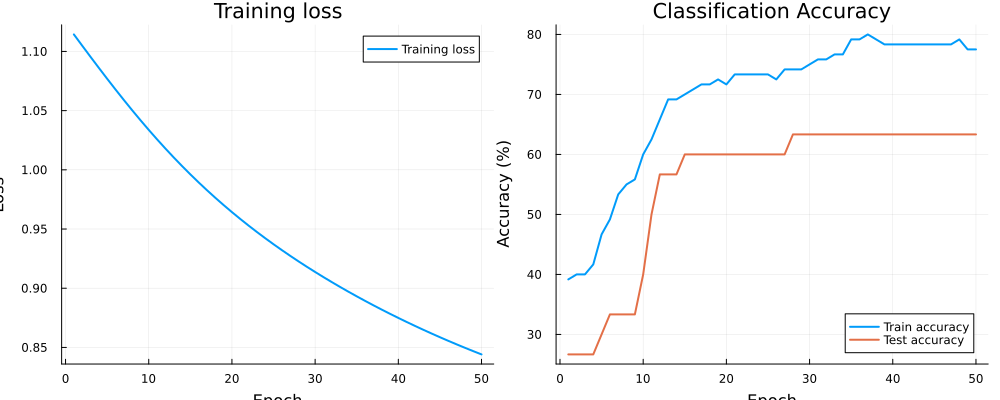

In [75]:
# ============================================================================
# VISUALIZATION
# ============================================================================
# Plot training metrics to analyze model performance

println("\nFinal results:")
println("Training accuracy: $(round(train_accs[end]*100, digits=2))%")
println("Test accuracy: $(round(test_accs[end]*100, digits=2))%")

# Create two subplots side by side

# Plot 1: Training loss over epochs
# Shows how well the model is learning (loss should decrease)
p1 = Plots.plot(train_losses, label="Training loss", xlabel="Epoch", ylabel="Loss",
    title="Training loss", lw=2, legend=:topright)

# Plot 2: Training and test accuracy over epochs
# Shows generalization: test accuracy should track training accuracy
# Large gap indicates overfitting
p2 = Plots.plot([train_accs.*100, test_accs.*100],
    label=["Train accuracy" "Test accuracy"],
    xlabel="Epoch", ylabel="Accuracy (%)",
    title="Classification Accuracy", lw=2, legend=:bottomright)

# Display both plots together
Plots.plot(p1, p2, layout=(1,2), size=(1000, 400))

# ============================================================================
# ANALYSIS OF RESULTS
# ============================================================================
# Expected behavior for a well-trained model:
# - Loss should decrease steadily
# - Training accuracy should increase toward 100%
# - Test accuracy should be close to training accuracy (no overfitting)
#
# OBSERVED BEHAVIOR (Current run):
# - Training accuracy: ~22.5% (VERY POOR - worse than random 33.3%)
# - Test accuracy: ~20% (POOR)
# - Loss decreasing slowly but model not learning effectively
#
# POSSIBLE REASONS FOR POOR PERFORMANCE:
# 1. Circuit expressivity: May need more layers or different architecture
# 2. Learning rate: 0.01 might be too small for this problem
# 3. Initialization: Random initialization might be far from optimal
# 4. Training epochs: 50 epochs may not be enough
# 5. Feature encoding: The encoding scheme may not be suitable
# 6. Measurement strategy: Using only 3 qubits for 3 classes limits expressivity
#
# IMPROVEMENTS TO TRY:
# - Increase learning rate (try 0.05 or 0.1)
# - Train for more epochs (100-200)
# - Use different feature encoding (amplitude encoding, etc.)
# - Add more variational layers
# - Use a different optimizer (Adam, RMSprop)
# - Implement batching to speed up training
# ============================================================================

### Analyse predictions

In [76]:
println("Sample predictions on test set:\n")

for i in 1:5
    probs = forward(model, X_test[i, :])
    pred = argmax(probs) - 1
    true_label = y_test[i]

    println("Sample $i:")
    println("   True label: $true_label")
    println("   Predicted: $pred")
    println("   Probabilities: $(round.(probs, digits=3))")
    println("   Correct: $(pred == true_label ? "̌✓" : "✗")")
    println()
end

Sample predictions on test set:

Sample 1:
   True label: 0
   Predicted: 0
   Probabilities: [0.557, 0.225, 0.218]
   Correct: ̌✓

Sample 2:
   True label: 2
   Predicted: 1
   Probabilities: [0.244, 0.38, 0.376]
   Correct: ✗

Sample 3:
   True label: 0
   Predicted: 0
   Probabilities: [0.529, 0.243, 0.227]
   Correct: ̌✓

Sample 4:
   True label: 0
   Predicted: 0
   Probabilities: [0.517, 0.256, 0.227]
   Correct: ̌✓

Sample 5:
   True label: 2
   Predicted: 1
   Probabilities: [0.25, 0.424, 0.326]
   Correct: ✗

